# CNN Tutorial
In this notebook you will learn to classify handwritten digits using a convolutional neural network.

Fill in the code after the TODO statements.

If you are stuck on an exercise for more than a few minutes, ask for clarification.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxNaeg/mnist_jax_tutorial/blob/main/cnn_tutorial_solution.ipynb)

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import tensorflow as tf # for loading the dataset
from flax import linen as nn # the neural-network library of flax
import optax # for optimization
from matplotlib import pyplot as plt # plotting

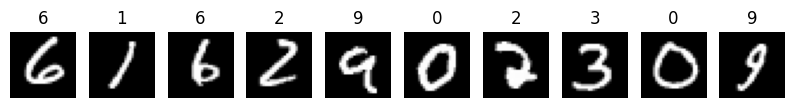

In [2]:
# Load mnist dataset using tensorflow
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

mean = np.mean(x_train)
std = np.std(x_train)
# Normalize input to zero mean and unit standard deviation.
# This is good practice for training neural networks to avoid training instabilities.
# This is the simplest form of normalization, but you can also use more advanced techniques like pixel-wise normalization.
# Also, add channel dimension (1 for grayscale)
x_train = (x_train[:, :, :, None] - mean) / (std + 1e-12)
x_test = (x_test[:, :, :, None] - mean) / (std + 1e-12)

# Visualize some of the data
num_images = 10

# Choose random index of the data
random_index = np.random.choice(range(len(x_train)), size=(num_images,), replace=False) ## replace = false for unique data

plt.figure(figsize=(num_images, 1))
for i, index in enumerate(random_index):
    plt.subplot(1, num_images, i+1)
    plt.imshow(x_train[index], cmap='gray')
    plt.title(y_train[index])
    plt.axis('off')
plt.show()



In [3]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
# x_train has shape (datset_size, height, width, channels)
# y_train has shape (dataset_size,)

(60000, 28, 28, 1) (60000,) (10000, 28, 28, 1) (10000,)


In [ ]:
# Define a simple convolutional neural network using flax
# The network starts with two convolutional layers, followed by a fully connected layer.

class ConvNetwork(nn.Module):
  conv_features: int
  output_neurons: int
  @nn.compact
  def __call__(self, x):
      # Here, x is the input data with shape (batch_size, height, width, channels)
      batchsize = x.shape[0]  # Get the batch size from the input shape (used later for flattening)
      # TODO: implement a simple convolutional neural network
      # 1. Convolutional layer with `self.conv_features` filters, kernel size (3, 3). Use nn.Conv.
      x = nn.Conv(features=self.conv_features, kernel_size=(3, 3))(x)
      # 2. ReLU activation, use `nn.relu` for this.
      x = nn.relu(x)
      # 3. Average pooling layer with window size (2, 2) and stride (2, 2), use nn.avg_pool.
      x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
      # 4. Another convolutional layer with `self.conv_features` filters, kernel size (3, 3)
      x = nn.Conv(features=self.conv_features, kernel_size=(3, 3))(x) 
      # 5. ReLU activation
      x = nn.relu(x)
      # 6. Average pooling layer with window size (2, 2) and stride (2, 2)
      x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))  # Pooling layer
      # 7. Flatten the output to make it suitable for a fully connected layer, use x.reshape.
      #    Make sure to not flatten the batch dimension. Ouput shape should be (batch_size, -1).
      x = x.reshape((batchsize, -1))
      # 8. Fully connected layer with `self.output_neurons` outputs, use nn.Dense
      x = nn.Dense(features=self.output_neurons)(x)
      return x # we do not apply any activation function here, as the loss function will handle it
     
# 8 output channels for the convolutional layers, 
# 10 output neurons for the fully connected layer since we have 10 classes in MNIST
network = ConvNetwork(conv_features=8, output_neurons=10)
random_key = jax.random.key(42)
params = network.init(random_key, x_train[:2]) # randomly initialize parameters

# Call network.apply, should have shape (2,10)
network.apply(params, x_train[:2]).shape 

(2, 10)

In [5]:
# Have a look at the way the parameters are stored inside a dictionary. 'kernel' means the weight matrix!
params
     


{'params': {'Conv_0': {'kernel': Array([[[[-0.14592372,  0.40967453, -0.10273962,  0.5451607 ,
             -0.30535382,  0.13827404,  0.12171835, -0.34430438]],
   
           [[-0.32906473, -0.31635576, -0.36602792,  0.3625747 ,
              0.4850592 ,  0.02078913,  0.53634447,  0.5399541 ]],
   
           [[-0.16622838, -0.00471988,  0.25473768,  0.093147  ,
             -0.30308273,  0.53679216,  0.20731153,  0.09175916]]],
   
   
          [[[ 0.2820754 ,  0.59517366,  0.5628614 ,  0.3446846 ,
             -0.24633263,  0.01485514, -0.20488253, -0.14140347]],
   
           [[-0.04899631,  0.40913746, -0.26533672, -0.14116652,
              0.64898723, -0.06959984,  0.16989468, -0.23118894]],
   
           [[-0.34221122, -0.6306476 ,  0.09517209, -0.53376764,
              0.14976726, -0.5521655 , -0.24485855, -0.03866476]]],
   
   
          [[[-0.12779684, -0.17688727,  0.16291441, -0.74551594,
             -0.20982784, -0.37739715, -0.43158874, -0.5545161 ]],
   
        

In [6]:
# TODO: Understand the shape of the parameters of the convolutional layers. 
# What is the meaning of each dimension of the kernel?
params['params']['Conv_0']['kernel'].shape, params['params']['Conv_1']['kernel'].shape
# The kernels have shape (height, width, input_channels, output_channels)

((3, 3, 1, 8), (3, 3, 8, 8))

In [22]:
# Define the cost function
def cost(params, x, y_target):
  # Here, x size is [batch_size, 28, 28, 1] and y_target size is [batch_size]
  #TODO: Finish the cost function
  # 1. Get logits by applying network and params.
  logits = network.apply(params, x) # shape (batch_size, 10)
  print(logits.shape)
  # 2. Get the one hot labels of the y_target, use jax.nn.one_hot
  one_hot_labels = jax.nn.one_hot(y_target, num_classes=10) # shape (batch_size, 10)
  # 3. Get the (normalized) log probabilities from the logits, 
  #    use jax.nn.log_softmax (look up its documentation, it's important that you understand the fromula!).
  #    We use jax.nn.log_softmax instead of implementing the softmax manually
  #    because it plays some tricks to avoid overflow/underflow issues in the exponentiation.
  normalized_log_probs = jax.nn.log_softmax(logits, axis=-1)
  # 4. Calculate the categorical cross entropy loss (look up its definition), use jnp.sum.
  loss_all = -jnp.sum(normalized_log_probs * one_hot_labels, axis=-1)
  # 4. Calulate the mean loss over the batch, use jnp.mean.
  loss = jnp.mean(loss_all)
  return loss

In [23]:
# test cost
cost(params, jnp.array(x_train[:2]), jnp.array(y_train[:2]))

(2, 10)


Array(0.00142574, dtype=float32)

In [9]:
# TODO: Create function that computes the cost and its gradient, use jax.value_and_grad
cost_grad = jax.value_and_grad(cost)
# TODO: Jit compile the cost_grad function for faster execution, use jax.jit
cost_grad = jax.jit(cost_grad)

In [10]:
num_epochs = 4 # number of times going through the complete dataset
batch_size = 32 
num_train = x_train.shape[0] # size of the training set
num_batches = num_train // batch_size # number of batches per epoch

learning_rate=0.001 # initial learning rate

# Initialize the parameters of the network
random_key = jax.random.key(42) # get a random key
params = network.init(random_key, x_train[:2])

# linear learning rate schedule that decreases the learning rate to 0 over the course of training
total_steps = num_epochs * (x_train.shape[0] // batch_size)
schedule_fn = optax.linear_schedule(
    init_value=learning_rate,
    end_value=0.0,
    transition_steps=total_steps
)
optimizer=optax.adam(schedule_fn)
opt_state=optimizer.init(params) # initialize the state of the optimizer

# Train on a single batch, lax.scan compatible version
def train_step(carry, batch):
    params, opt_state = carry
    x_batch, y_batch = batch
    # TODO: Calculate the cost and its gradient
    cost, grads = cost_grad(params, x_batch, y_batch)
    # Update the parameters using the optimizer
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

    return (params, opt_state), cost

train_cost_history_all = [] # loss for each batch
train_cost_history_mean = [] # mean loss for each epoch
test_cost_history = [] # loss on test set after each epoch
# Get initial performance
test_cost_history.append(cost(params, x_test, y_test))
train_cost_history_mean.append(cost(params, x_train, y_train))  # Initialize with the mean of an empty list
print(f"Untrained, Mean train loss: {train_cost_history_mean[-1]:.4f}, Test loss: {test_cost_history[-1]:.4f}")

for epoch in range(num_epochs):
    # Shuffle the data to make sure the batches contain different samples each epoch.
    # This helps with avoiding overfitting.
    random_key, subkey = jax.random.split(random_key)
    permutation = jax.random.permutation(subkey, num_train)
    x_shuffled = x_train[permutation]
    y_shuffled = y_train[permutation]

    # Create batches from the shuffled data in a way that is compatible with lax.scan
    x_batches = x_shuffled[:num_batches * batch_size].reshape((num_batches, batch_size, 28, 28, 1))
    y_batches = y_shuffled[:num_batches * batch_size].reshape((num_batches, batch_size))

    # Scan over batches of one epoch
    (params, opt_state), costs = jax.lax.scan(
        train_step,
        (params, opt_state),
        (x_batches, y_batches)
    )
    train_cost_history_all.extend(list(costs)) # Append the loss for each batch
    train_cost_history_mean.append(jnp.mean(costs))  # Append the mean of the current epoch costs
    # Get performance on test set
    test_cost_history.append(cost(params, x_test, y_test))
    print(f"Epoch {epoch + 1}, Mean train loss: {train_cost_history_mean[-1]:.4f}, Test loss: {test_cost_history[-1]:.4f}")

Untrained, Mean train loss: 2.3187, Test loss: 2.3173
Epoch 1, Mean train loss: 0.2662, Test loss: 0.1123
Epoch 2, Mean train loss: 0.1053, Test loss: 0.0788
Epoch 3, Mean train loss: 0.0804, Test loss: 0.0646
Epoch 4, Mean train loss: 0.0678, Test loss: 0.0591


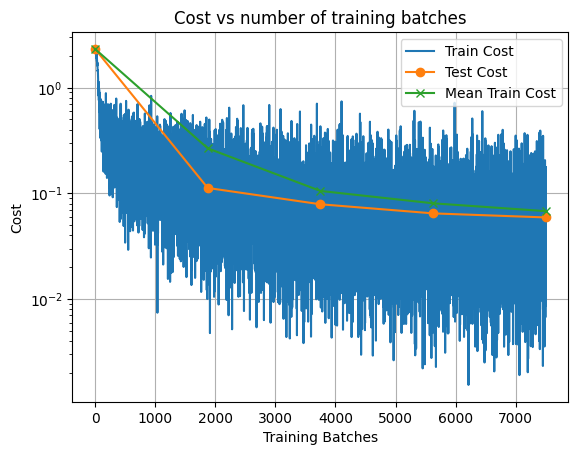

In [11]:
# Plot the training cost history
plt.plot(train_cost_history_all, label='Train Cost')
plt.plot(np.linspace(0, len(train_cost_history_all), len(test_cost_history)).astype(np.int32), 
         test_cost_history, label='Test Cost', marker='o')
plt.plot(np.linspace(0, len(train_cost_history_all), len(train_cost_history_mean)).astype(np.int32),
            train_cost_history_mean, label='Mean Train Cost', marker='x')
plt.title("Cost vs number of training batches")
plt.xlabel("Training Batches")
plt.ylabel("Cost")
plt.yscale('log')
plt.legend()

plt.grid()


In [12]:
# Calculate accuracy on test set
result = jnp.argmax(network.apply(params, x_test), axis=-1) # get the predicted labels
accuracy = jnp.mean(result == y_test) # calculate the accuracy
print(f"Test accuracy: {accuracy:.4f}")

Test accuracy: 0.9811


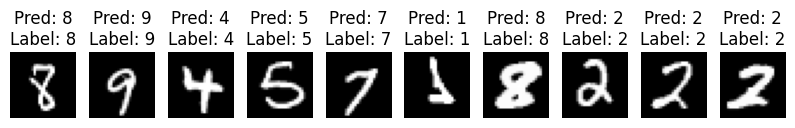

In [13]:
# Visualize some of the data
num_images = 10
random_key,new_key=jax.random.split(random_key)
random_index = jax.random.choice(new_key,jnp.array(range(x_test.shape[0])), shape=(num_images,), replace = False) ## replace = false for unique data
plt.figure(figsize=(num_images, 1))
for i, index in enumerate(random_index):
    plt.subplot(1, num_images, i+1)
    plt.imshow(x_test[index], cmap='gray')
    plt.title('Pred: %d\nLabel: %d' % (result[index], y_test[index]))
    plt.axis('off')
plt.show()

# Bonus Exercises:

In [14]:
# TODO: Try to train for 30 epochs: You will see that the training loss keeps improving, 
# while the test loss does not improve anymore after a while. This is a sign of overfitting.
# Implement early-stopping by stopping the training if the best test loss is at least 3 epochs in the past.

num_epochs = 30 # number of times going through the complete dataset
batch_size = 32 
num_train = x_train.shape[0] # size of the training set
num_batches = num_train // batch_size # number of batches per epoch

learning_rate=0.001 # initial learning rate

# Initialize the parameters of the network
random_key = jax.random.key(42) # get a random key
params = network.init(random_key, x_train[:2])

# linear learning rate schedule that decreases the learning rate to 0 over the course of training
total_steps = num_epochs * (x_train.shape[0] // batch_size)
schedule_fn = optax.linear_schedule(
    init_value=learning_rate,
    end_value=0.0,
    transition_steps=total_steps
)
optimizer=optax.adam(schedule_fn)
opt_state=optimizer.init(params) # initialize the state of the optimizer

# Train on a single batch, lax.scan compatible version
def train_step(carry, batch):
    params, opt_state = carry
    x_batch, y_batch = batch
    # TODO: Calculate the cost and its gradient
    cost, grads = cost_grad(params, x_batch, y_batch)
    # Update the parameters using the optimizer
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

    return (params, opt_state), cost

train_cost_history_all = [] # loss for each batch
train_cost_history_mean = [] # mean loss for each epoch
test_cost_history = [] # loss on test set after each epoch
# Get initial performance
test_cost_history.append(cost(params, x_test, y_test))
train_cost_history_mean.append(cost(params, x_train, y_train))  # Initialize with the mean of an empty list
print(f"Untrained, Mean train loss: {train_cost_history_mean[-1]:.4f}, Test loss: {test_cost_history[-1]:.4f}")

for epoch in range(num_epochs):
    # Shuffle the data to make sure the batches contain different samples each epoch.
    # This helps with avoiding overfitting.
    random_key, subkey = jax.random.split(random_key)
    permutation = jax.random.permutation(subkey, num_train)
    x_shuffled = x_train[permutation]
    y_shuffled = y_train[permutation]

    # Create batches from the shuffled data in a way that is compatible with lax.scan
    x_batches = x_shuffled[:num_batches * batch_size].reshape((num_batches, batch_size, 28, 28, 1))
    y_batches = y_shuffled[:num_batches * batch_size].reshape((num_batches, batch_size))

    # Scan over batches of one epoch
    (params, opt_state), costs = jax.lax.scan(
        train_step,
        (params, opt_state),
        (x_batches, y_batches)
    )
    train_cost_history_all.extend(list(costs)) # Append the loss for each batch
    train_cost_history_mean.append(jnp.mean(costs))  # Append the mean of the current epoch costs
    # Get performance on test set
    test_cost_history.append(cost(params, x_test, y_test))
    print(f"Epoch {epoch + 1}, Mean train loss: {train_cost_history_mean[-1]:.4f}, Test loss: {test_cost_history[-1]:.4f}")
    # Early stopping
    best_test_loss_idx = np.argmin(test_cost_history)  # Get the index of the best test loss so far
    if best_test_loss_idx < len(test_cost_history) - 3:
        print("Early stopping triggered: Test loss did not improve for three epochs.")
        break
    

Untrained, Mean train loss: 2.3187, Test loss: 2.3173
Epoch 1, Mean train loss: 0.2633, Test loss: 0.1078
Epoch 2, Mean train loss: 0.1008, Test loss: 0.0733
Epoch 3, Mean train loss: 0.0765, Test loss: 0.0626
Epoch 4, Mean train loss: 0.0634, Test loss: 0.0487
Epoch 5, Mean train loss: 0.0563, Test loss: 0.0597
Epoch 6, Mean train loss: 0.0520, Test loss: 0.0470
Epoch 7, Mean train loss: 0.0473, Test loss: 0.0447
Epoch 8, Mean train loss: 0.0435, Test loss: 0.0481
Epoch 9, Mean train loss: 0.0413, Test loss: 0.0482
Epoch 10, Mean train loss: 0.0386, Test loss: 0.0440
Epoch 11, Mean train loss: 0.0363, Test loss: 0.0456
Epoch 12, Mean train loss: 0.0344, Test loss: 0.0432
Epoch 13, Mean train loss: 0.0331, Test loss: 0.0403
Epoch 14, Mean train loss: 0.0313, Test loss: 0.0453
Epoch 15, Mean train loss: 0.0300, Test loss: 0.0421
Epoch 16, Mean train loss: 0.0285, Test loss: 0.0444
Early stopping triggered: Test loss did not improve for three epochs.


In [15]:
# TODO: Try to play around with the parameters (e.g. layers, channels, ...) and see how it affect the training progress.
# Try to get a higher accuracy.

In [ ]:
# TODO (more challenging): Implement a ResNet or U-Net (look them up online) and see if you further improve the accuracy.